In [5]:
import casadi as ca
import sys
sys.path.insert(0, '../python/pyecca')

import matplotlib.pyplot as plt
from pyecca.util import rk4
import numpy as np

from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())


In [51]:
def numerical(x_end, n_x):
    """
    Edit this function and setup an optimal control problem that minimizes the time
    it takes for a ball rolling a long a curve to reach the end of the path assuming it
    starts at a height of 1 m and ends at a height of 0 m and the length of the path is
    x_end m.
    """
    x_pos = np.linspace(0, x_end, n_x)  # x position where path changes
    n_dy = n_x - 1  # number of height changes we need to find
    dy_pos_guess = -(1/n_dy)*np.ones(n_dy)  # initial guess for height change along path
    
    x_1 = x_pos[0]
    x_2 = x_pos[-1]
    y_1 = 1
    y_2 = 0
        
    dy_pos = ca.SX.sym('y_pos',n_x-1)
    nlp = {'x': dy_pos, 'f': t12(x_pos,dy_pos), 'g': y_1+ca.sum1(dy_pos)}#Vary dy_pos to minimiz OF 'f' constrained by the sum of dy's = -1
    tmin = ca.nlpsol('tmin', 'ipopt', nlp, {
    'print_time': 0,
    'ipopt': {
        'sb': 'yes',
        'print_level': 0,
        }
    })
    res = tmin(x0=dy_pos_guess,lbg=y_2,ubg=y_2) 
    dy_opt = res['x']
    y_opt = np.concatenate((np.array([y_1]),y_1+np.cumsum(dy_opt)),axis=0)
    return x_pos, y_opt


def t12(x_pos,dy_pos):
    g = 9.81
    y = 1 #set initial height
    t_total = 0
    dx = np.mean(np.diff(x_pos))
    
    for i in range(len(x_pos)-1):
        dy = dy_pos[i]
        length = ca.sqrt(ca.power(dy,2)+ca.power(dx,2))
        dt = 2*length/(ca.sqrt(2*g*(1-y))+ca.sqrt(2*g*(1-y-dy)))
        t_total = t_total + dt
        y = y + dy
    
    return t_total

In [52]:
# NLP declaration to solve for boundary condition of brachistochrone
def analytical(x_end, n_x):
    c = ca.SX.sym('c')
    theta_f = ca.SX.sym('theta_f')
    xf = c*(theta_f - np.sin(theta_f))
    yf = 1 - c*(1 - np.cos(theta_f))

    nlp = {'x':ca.vertcat(c, theta_f), 'f':0,'g':ca.vertcat(xf-x_end,yf)}
    S = ca.nlpsol('S', 'ipopt', nlp, {
        'print_time': 0,
        'ipopt': {
            'sb': 'yes',
            'print_level': 0,
            }
        })
    res = S(x0=(1, np.pi), lbg=(0, 0), ubg=(0, 0))
    C_opt = float(res['x'][0])
    theta_f_opt = float(res['x'][1])
    theta = np.linspace(0, theta_f_opt, n_x)
    xa = C_opt*(theta - np.sin(theta))
    ya = 1 - C_opt*(1 - np.cos(theta))
    return xa, ya

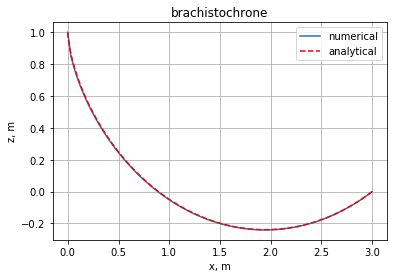

In [53]:
n_x = 100  # number of points for approximation of path
x_end = 3  # final x position when height is zero

# analytical solution
xa, ya = analytical(x_end=x_end, n_x=n_x)

# numerical solution
x, y_opt = numerical(x_end=x_end, n_x=n_x)

# plot
plt.title('brachistochrone')
plt.plot(x, y_opt, label='numerical')
plt.plot(xa, ya, 'r--', label='analytical')
plt.grid(True)
plt.xlabel('x, m')
plt.ylabel('z, m')
plt.legend()